Skin Cancer Classification Final Project

In [7]:
# importing dataset
import kagglehub
import os
import pandas as pd
import shutil


dataset_path = kagglehub.dataset_download("jaiahuja/skin-cancer-detection")

# Move/copy to current working directory in Colab
!mkdir -p /content/SkinCancer
shutil.copytree(dataset_path, '/content/SkinCancer', dirs_exist_ok=True)

train_path = 'Train'
test_path = 'Test'

100%|██████████| 786M/786M [00:37<00:00, 22.1MB/s]

Extracting files...


In [4]:
# declaring global variables
BATCH_SIZE = 32
HEIGHT_IMG = 180
WIDTH_IMG = 180

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import os
import matplotlib.pyplot as plt
# import glob

transform = transforms.Compose([
    transforms.Resize((HEIGHT_IMG, WIDTH_IMG)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder("Train", transform=transform)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = datasets.ImageFolder("Test", transform=transform)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# images, labels = next(iter(train_loader))
# print(f'Image batch shape: {images.size()}')
# print(f'Label batch shape: {labels.size()}')





In [10]:

validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # first convolutional layer input 3 channels (RGB) outputs 16 feature maps
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # maxpool reduces width and height by a factor of 2 and extract dominant features
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 16 feature map input, 32 output feature maps
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # 32 feature map input, 64 output feature maps
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)


        # fully connected layers
        #dense layer
        self.fc1 = nn.Linear(30976, 128)
        self.fc2 = nn.Linear(128, 9)  # Assuming binary classification

    def forward(self, x):
        # x /= 255.0  # Normalize input to [0, 1]

        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)
        # remember to always zero out the gradient first. Don't want old values
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # tracking prog
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / total
    train_loss_epoch = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            # optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = 100 * val_correct / total_val
    val_loss_epoch = val_loss / len(val_loader)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.9330, Accuracy: 27.73%


  5%|▌         | 1/20 [00:08<02:40,  8.45s/it]

Validation Loss: 1.8408, Validation Accuracy: 32.44%
Epoch 2/20, Loss: 1.6469, Accuracy: 41.46%


 10%|█         | 2/20 [00:16<02:30,  8.36s/it]

Validation Loss: 1.4947, Validation Accuracy: 45.86%
Epoch 3/20, Loss: 1.4838, Accuracy: 47.27%


 15%|█▌        | 3/20 [00:25<02:24,  8.49s/it]

Validation Loss: 1.5062, Validation Accuracy: 46.09%
Epoch 4/20, Loss: 1.3549, Accuracy: 51.79%


 20%|██        | 4/20 [00:33<02:15,  8.48s/it]

Validation Loss: 1.3384, Validation Accuracy: 53.69%
Epoch 5/20, Loss: 1.2796, Accuracy: 55.02%


 25%|██▌       | 5/20 [00:42<02:06,  8.44s/it]

Validation Loss: 1.3013, Validation Accuracy: 55.26%
Epoch 6/20, Loss: 1.2773, Accuracy: 54.80%


 30%|███       | 6/20 [00:50<01:57,  8.41s/it]

Validation Loss: 1.3016, Validation Accuracy: 53.91%
Epoch 7/20, Loss: 1.1321, Accuracy: 60.44%


 35%|███▌      | 7/20 [00:59<01:49,  8.42s/it]

Validation Loss: 1.3009, Validation Accuracy: 53.69%
Epoch 8/20, Loss: 1.1733, Accuracy: 58.65%


 40%|████      | 8/20 [01:07<01:40,  8.39s/it]

Validation Loss: 1.3257, Validation Accuracy: 52.57%
Epoch 9/20, Loss: 1.0324, Accuracy: 63.34%


 45%|████▌     | 9/20 [01:15<01:32,  8.42s/it]

Validation Loss: 1.3334, Validation Accuracy: 54.81%
Epoch 10/20, Loss: 0.9755, Accuracy: 65.74%


 50%|█████     | 10/20 [01:24<01:23,  8.37s/it]

Validation Loss: 1.4194, Validation Accuracy: 53.69%
Epoch 11/20, Loss: 0.9593, Accuracy: 66.13%


 55%|█████▌    | 11/20 [01:32<01:16,  8.45s/it]

Validation Loss: 1.3202, Validation Accuracy: 54.14%
Epoch 12/20, Loss: 0.7753, Accuracy: 72.04%


 60%|██████    | 12/20 [01:41<01:07,  8.46s/it]

Validation Loss: 1.3789, Validation Accuracy: 54.14%
Epoch 13/20, Loss: 0.7015, Accuracy: 75.61%


 65%|██████▌   | 13/20 [01:49<00:58,  8.40s/it]

Validation Loss: 1.6694, Validation Accuracy: 51.45%
Epoch 14/20, Loss: 0.6409, Accuracy: 76.73%


 70%|███████   | 14/20 [01:57<00:50,  8.37s/it]

Validation Loss: 1.5478, Validation Accuracy: 53.69%
Epoch 15/20, Loss: 0.5820, Accuracy: 78.85%


 75%|███████▌  | 15/20 [02:05<00:41,  8.30s/it]

Validation Loss: 1.8731, Validation Accuracy: 50.78%
Epoch 16/20, Loss: 0.5965, Accuracy: 78.07%


 80%|████████  | 16/20 [02:14<00:33,  8.31s/it]

Validation Loss: 1.8493, Validation Accuracy: 49.89%
Epoch 17/20, Loss: 0.4587, Accuracy: 82.31%


 85%|████████▌ | 17/20 [02:22<00:24,  8.29s/it]

Validation Loss: 1.8089, Validation Accuracy: 51.01%
Epoch 18/20, Loss: 0.4052, Accuracy: 83.76%


 90%|█████████ | 18/20 [02:31<00:16,  8.39s/it]

Validation Loss: 1.9399, Validation Accuracy: 51.68%
Epoch 19/20, Loss: 0.4558, Accuracy: 83.26%


 95%|█████████▌| 19/20 [02:39<00:08,  8.44s/it]

Validation Loss: 1.9378, Validation Accuracy: 50.78%
Epoch 20/20, Loss: 0.3361, Accuracy: 86.94%


100%|██████████| 20/20 [02:48<00:00,  8.41s/it]

Validation Loss: 2.1394, Validation Accuracy: 53.02%


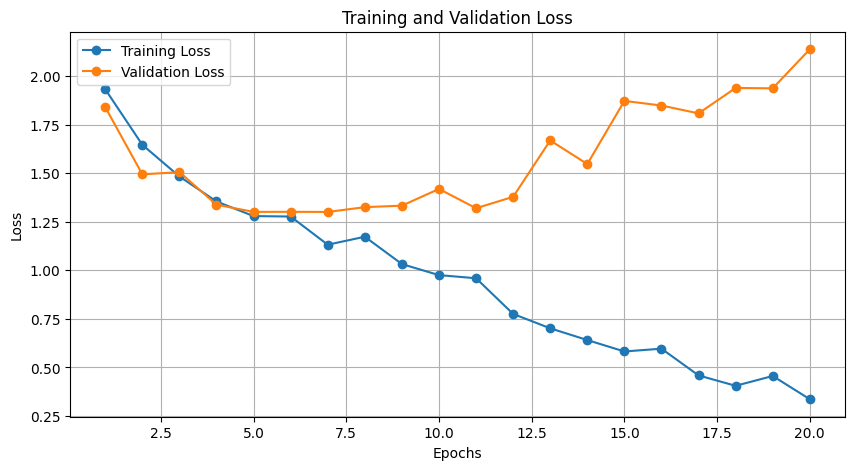

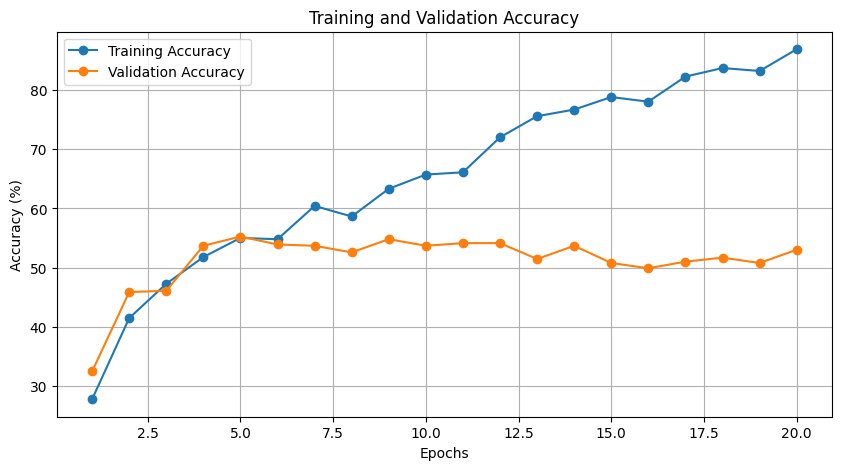

In [ ]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

We will now perform data augmentation to try to reduce this overfitting behavior.

In [18]:
from tqdm import tqdm




training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomResizedCrop((HEIGHT_IMG, WIDTH_IMG), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("Train", transform=training_transform)


validation_transform = transforms.Compose([
    transforms.Resize((HEIGHT_IMG, WIDTH_IMG)),
    transforms.ToTensor(),
])

validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Re-training the model with augmented data

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)
        # remember to always zero out the gradient first. Don't want old values
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # tracking prog
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / total
    train_loss_epoch = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            # optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = 100 * val_correct / total_val
    val_loss_epoch = val_loss / len(val_loader)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')





  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 2.0359, Accuracy: 19.36%


  5%|▌         | 1/20 [00:09<03:05,  9.74s/it]

Validation Loss: 2.0011, Validation Accuracy: 20.13%
Epoch 2/20, Loss: 1.8514, Accuracy: 30.80%


 10%|█         | 2/20 [00:19<02:51,  9.50s/it]

Validation Loss: 1.7499, Validation Accuracy: 38.03%
Epoch 3/20, Loss: 1.6582, Accuracy: 39.96%


 15%|█▌        | 3/20 [00:28<02:42,  9.54s/it]

Validation Loss: 1.5994, Validation Accuracy: 44.52%
Epoch 4/20, Loss: 1.5119, Accuracy: 46.60%


 20%|██        | 4/20 [00:38<02:32,  9.50s/it]

Validation Loss: 1.5032, Validation Accuracy: 48.10%
Epoch 5/20, Loss: 1.4215, Accuracy: 51.12%


 25%|██▌       | 5/20 [00:47<02:22,  9.48s/it]

Validation Loss: 1.5512, Validation Accuracy: 46.53%
Epoch 6/20, Loss: 1.3901, Accuracy: 51.45%


 30%|███       | 6/20 [00:57<02:12,  9.49s/it]

Validation Loss: 1.4658, Validation Accuracy: 50.56%
Epoch 7/20, Loss: 1.3064, Accuracy: 55.47%


 35%|███▌      | 7/20 [01:06<02:03,  9.50s/it]

Validation Loss: 1.4963, Validation Accuracy: 46.76%
Epoch 8/20, Loss: 1.2544, Accuracy: 56.64%


 40%|████      | 8/20 [01:15<01:53,  9.46s/it]

Validation Loss: 1.4802, Validation Accuracy: 46.76%
Epoch 9/20, Loss: 1.2333, Accuracy: 55.86%


 45%|████▌     | 9/20 [01:25<01:44,  9.52s/it]

Validation Loss: 1.3676, Validation Accuracy: 52.13%
Epoch 10/20, Loss: 1.2178, Accuracy: 58.15%


 50%|█████     | 10/20 [01:35<01:35,  9.50s/it]

Validation Loss: 1.4760, Validation Accuracy: 47.65%
Epoch 11/20, Loss: 1.1840, Accuracy: 58.48%


 55%|█████▌    | 11/20 [01:44<01:25,  9.48s/it]

Validation Loss: 1.3414, Validation Accuracy: 51.68%
Epoch 12/20, Loss: 1.1551, Accuracy: 58.93%


 60%|██████    | 12/20 [01:54<01:16,  9.54s/it]

Validation Loss: 1.3432, Validation Accuracy: 52.35%
Epoch 13/20, Loss: 1.1249, Accuracy: 60.10%


 65%|██████▌   | 13/20 [02:03<01:06,  9.56s/it]

Validation Loss: 1.3965, Validation Accuracy: 51.45%
Epoch 14/20, Loss: 1.0782, Accuracy: 62.00%


 70%|███████   | 14/20 [02:13<00:56,  9.50s/it]

Validation Loss: 1.5718, Validation Accuracy: 47.43%
Epoch 15/20, Loss: 1.0968, Accuracy: 61.33%


 75%|███████▌  | 15/20 [02:22<00:47,  9.56s/it]

Validation Loss: 1.3652, Validation Accuracy: 55.03%
Epoch 16/20, Loss: 1.0325, Accuracy: 63.06%


 80%|████████  | 16/20 [02:32<00:38,  9.51s/it]

Validation Loss: 1.3656, Validation Accuracy: 49.22%
Epoch 17/20, Loss: 1.0061, Accuracy: 63.56%


 85%|████████▌ | 17/20 [02:42<00:28,  9.60s/it]

Validation Loss: 1.3821, Validation Accuracy: 51.90%
Epoch 18/20, Loss: 1.0102, Accuracy: 63.95%


 90%|█████████ | 18/20 [02:51<00:19,  9.56s/it]

Validation Loss: 1.3555, Validation Accuracy: 55.93%
Epoch 19/20, Loss: 0.9767, Accuracy: 65.23%


 95%|█████████▌| 19/20 [03:00<00:09,  9.53s/it]

Validation Loss: 1.3706, Validation Accuracy: 53.91%
Epoch 20/20, Loss: 0.9621, Accuracy: 65.62%


100%|██████████| 20/20 [03:10<00:00,  9.52s/it]

Validation Loss: 1.3856, Validation Accuracy: 55.70%


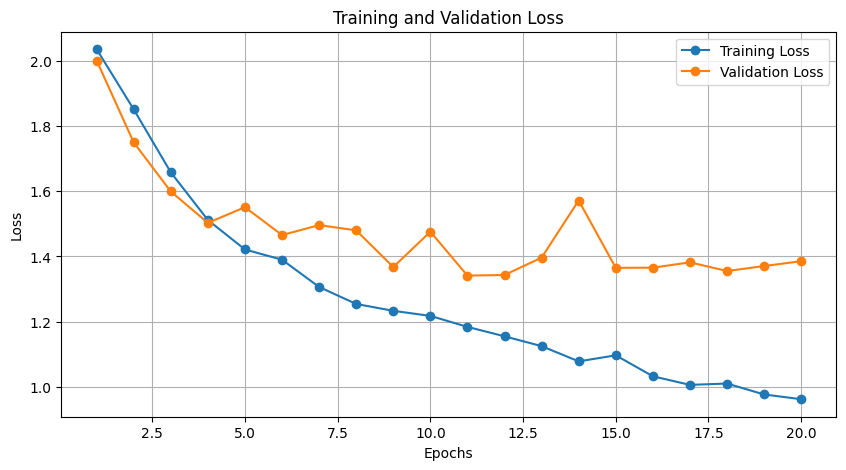

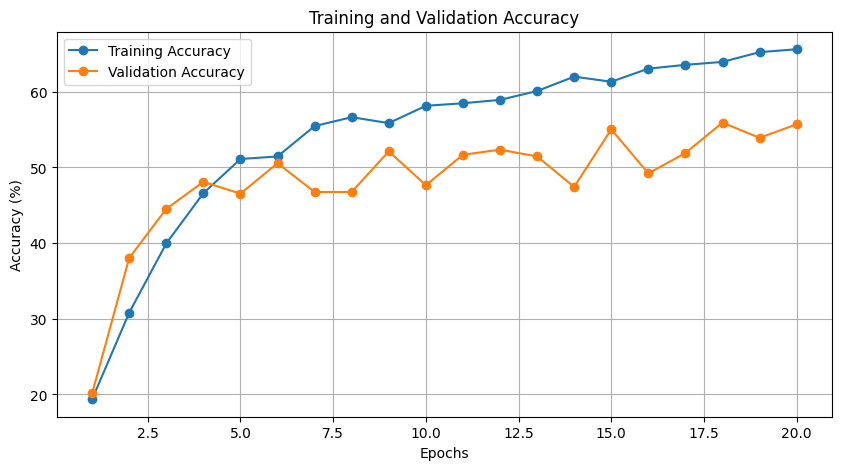

In [19]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

As we can see from above, the training and validation accuracies are much more closer to eachother! Next we can experiment with adding a dropout layers alongside with batch normalization in our CNN model to see if this will further improve our model.


In [34]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # first convolutional layer input 3 channels (RGB) outputs 16 feature maps
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # maxpool reduces width and height by a factor of 2 and extract dominant features
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 16 feature map input, 32 output feature maps
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # 32 feature map input, 64 output feature maps
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # Dropout layer
        self.dropout_conv = nn.Dropout2d(0.1)

        # fully connected layers
        #dense layer
        self.fc1 = nn.Linear(30976, 128)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 9)  # Assuming binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.dropout_conv(x)
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [29]:
from tqdm import tqdm




training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomResizedCrop((HEIGHT_IMG, WIDTH_IMG), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("Train", transform=training_transform)


validation_transform = transforms.Compose([
    transforms.Resize((HEIGHT_IMG, WIDTH_IMG)),
    transforms.ToTensor(),
])

validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Re-training the model with augmented data

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)
        # remember to always zero out the gradient first. Don't want old values
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # tracking prog
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / total
    train_loss_epoch = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            # optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = 100 * val_correct / total_val
    val_loss_epoch = val_loss / len(val_loader)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')





  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 2.6944, Accuracy: 26.12%


  5%|▌         | 1/20 [00:09<02:58,  9.41s/it]

Validation Loss: 1.8588, Validation Accuracy: 36.24%
Epoch 2/20, Loss: 1.9156, Accuracy: 28.96%


 10%|█         | 2/20 [00:18<02:50,  9.45s/it]

Validation Loss: 1.7477, Validation Accuracy: 42.28%
Epoch 3/20, Loss: 1.8521, Accuracy: 34.77%


 15%|█▌        | 3/20 [00:28<02:41,  9.47s/it]

Validation Loss: 1.7567, Validation Accuracy: 37.14%
Epoch 4/20, Loss: 1.7884, Accuracy: 34.93%


 20%|██        | 4/20 [00:37<02:31,  9.50s/it]

Validation Loss: 1.6189, Validation Accuracy: 46.53%
Epoch 5/20, Loss: 1.7223, Accuracy: 38.90%


 25%|██▌       | 5/20 [00:47<02:21,  9.42s/it]

Validation Loss: 1.7526, Validation Accuracy: 38.70%
Epoch 6/20, Loss: 1.6941, Accuracy: 39.90%


 30%|███       | 6/20 [00:57<02:14,  9.58s/it]

Validation Loss: 1.5907, Validation Accuracy: 45.19%
Epoch 7/20, Loss: 1.7322, Accuracy: 38.17%


 35%|███▌      | 7/20 [01:06<02:03,  9.49s/it]

Validation Loss: 1.5655, Validation Accuracy: 44.30%
Epoch 8/20, Loss: 1.6794, Accuracy: 39.17%


 40%|████      | 8/20 [01:15<01:53,  9.48s/it]

Validation Loss: 1.7694, Validation Accuracy: 38.48%
Epoch 9/20, Loss: 1.6390, Accuracy: 40.29%


 45%|████▌     | 9/20 [01:25<01:44,  9.52s/it]

Validation Loss: 1.5133, Validation Accuracy: 43.40%
Epoch 10/20, Loss: 1.6870, Accuracy: 39.29%


 50%|█████     | 10/20 [01:35<01:35,  9.53s/it]

Validation Loss: 1.4467, Validation Accuracy: 50.78%
Epoch 11/20, Loss: 1.6235, Accuracy: 40.29%


 55%|█████▌    | 11/20 [01:44<01:26,  9.58s/it]

Validation Loss: 1.4967, Validation Accuracy: 49.89%
Epoch 12/20, Loss: 1.5728, Accuracy: 42.08%


 60%|██████    | 12/20 [01:54<01:16,  9.52s/it]

Validation Loss: 1.4583, Validation Accuracy: 47.87%
Epoch 13/20, Loss: 1.6233, Accuracy: 41.24%


 65%|██████▌   | 13/20 [02:03<01:05,  9.42s/it]

Validation Loss: 1.4580, Validation Accuracy: 48.77%
Epoch 14/20, Loss: 1.5921, Accuracy: 43.92%


 70%|███████   | 14/20 [02:12<00:57,  9.51s/it]

Validation Loss: 1.4269, Validation Accuracy: 49.44%
Epoch 15/20, Loss: 1.5655, Accuracy: 42.86%


 75%|███████▌  | 15/20 [02:22<00:47,  9.54s/it]

Validation Loss: 2.2326, Validation Accuracy: 38.70%
Epoch 16/20, Loss: 1.5506, Accuracy: 43.69%


 80%|████████  | 16/20 [02:32<00:38,  9.70s/it]

Validation Loss: 1.4086, Validation Accuracy: 50.34%
Epoch 17/20, Loss: 1.5140, Accuracy: 44.87%


 85%|████████▌ | 17/20 [02:41<00:28,  9.57s/it]

Validation Loss: 1.4323, Validation Accuracy: 49.66%
Epoch 18/20, Loss: 1.5151, Accuracy: 46.65%


 90%|█████████ | 18/20 [02:51<00:19,  9.70s/it]

Validation Loss: 1.4160, Validation Accuracy: 51.23%
Epoch 19/20, Loss: 1.5033, Accuracy: 44.81%


 95%|█████████▌| 19/20 [03:01<00:09,  9.67s/it]

Validation Loss: 1.3746, Validation Accuracy: 51.45%
Epoch 20/20, Loss: 1.5112, Accuracy: 45.98%


100%|██████████| 20/20 [03:11<00:00,  9.57s/it]

Validation Loss: 1.6662, Validation Accuracy: 46.53%


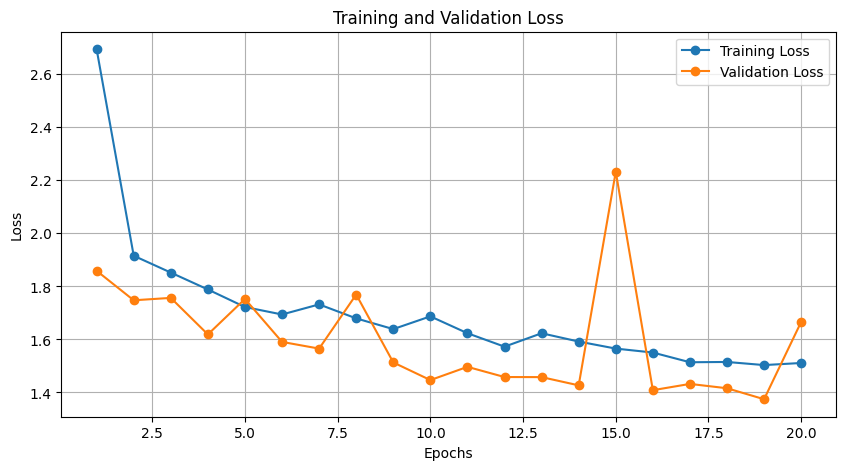

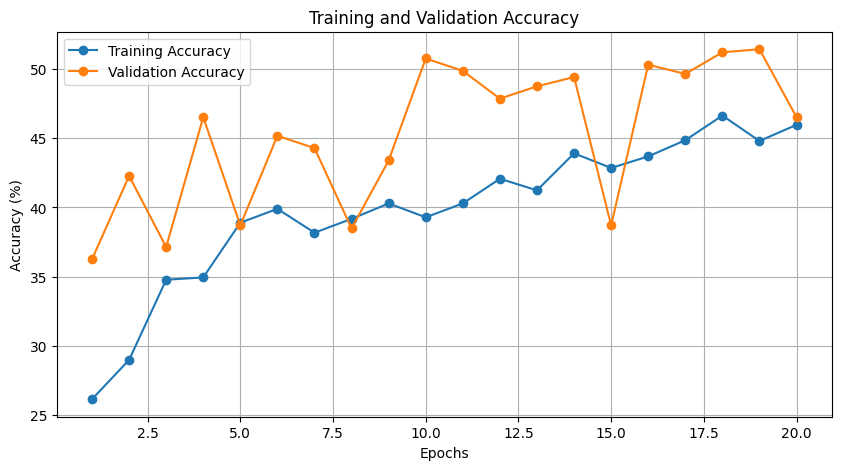

In [30]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

After adding dropout and batch normalization, we see that the validation accuracy and losses are much more noisy, however this is expected due to dropout turning off neurons during training. As we analyze the models performance with dropout and batch normalization vs without, we see that the model reaches a validation accuracy of ~50% for the new model vs ~55% for the old model, so right now the old model is performing better. After doing research online, we found out that this is usually expected behavior for small CNN models as batch normalization helps with deeper CNN models, and dropout only helps when the model is overfitting strongly, but in our case after data augmentation the overfitting was heavily reduced.

Next, we experimented with lowering dropout probability in the parameters for the dropout layers, alongside with increasing epoch to 40.

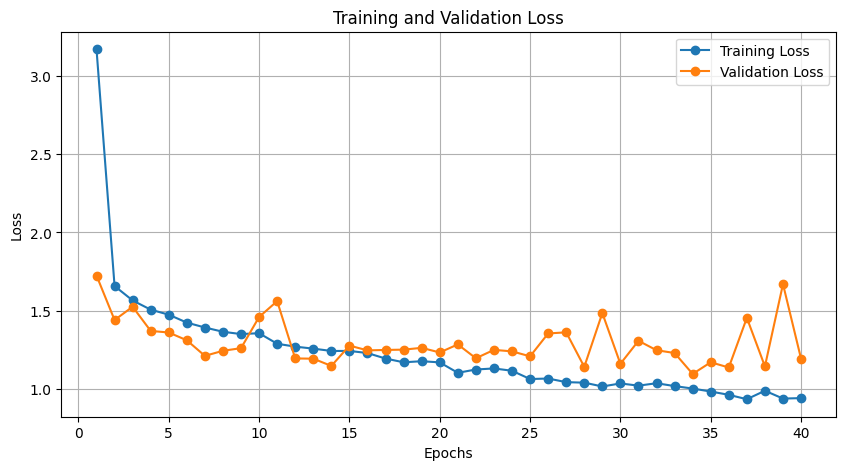

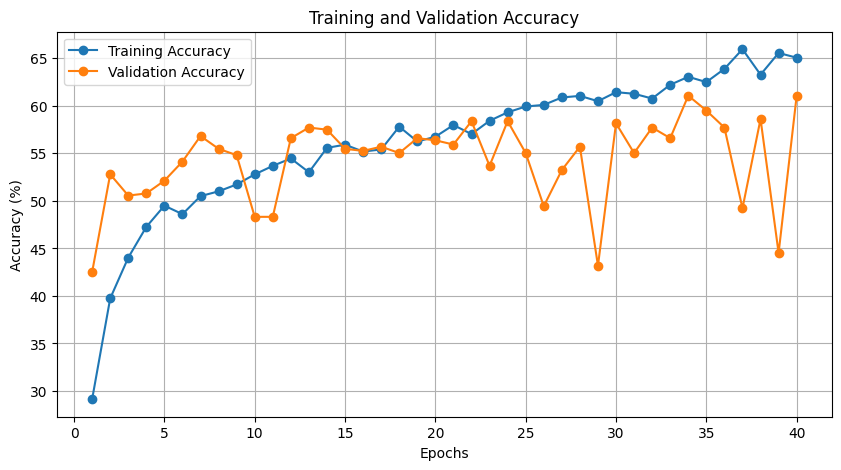

In [27]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

The last optimization we can experiment with to see if it will improve our model's performance is adding weighted loss, this will make errors on the minority classes much more expensive and will force our CNN to focus on the minority class rather than the majority class to improve generalization


In [31]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

all_labels = [train_dataset[i][1]for i in range(len(train_dataset))]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# now we will pass the class weights to the criterion / loss function

In [35]:
from tqdm import tqdm




training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomResizedCrop((HEIGHT_IMG, WIDTH_IMG), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("Train", transform=training_transform)


validation_transform = transforms.Compose([
    transforms.Resize((HEIGHT_IMG, WIDTH_IMG)),
    transforms.ToTensor(),
])

validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size
train_dataset, val_dataset = random_split(train_data, [training_size, validation_size])



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Re-training the model with augmented data

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

epochs = 40

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)
        # remember to always zero out the gradient first. Don't want old values
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # tracking prog
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / total
    train_loss_epoch = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for image, labels in val_loader:
            image, labels = image.to(device), labels.to(device)
            # optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = 100 * val_correct / total_val
    val_loss_epoch = val_loss / len(val_loader)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')





  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Loss: 2.8303, Accuracy: 6.81%


  2%|▎         | 1/40 [00:09<05:56,  9.14s/it]

Validation Loss: 2.1806, Validation Accuracy: 5.15%
Epoch 2/40, Loss: 2.1776, Accuracy: 11.89%


  5%|▌         | 2/40 [00:18<05:49,  9.19s/it]

Validation Loss: 2.1553, Validation Accuracy: 13.42%
Epoch 3/40, Loss: 2.1119, Accuracy: 16.24%


  8%|▊         | 3/40 [00:27<05:43,  9.29s/it]

Validation Loss: 2.1761, Validation Accuracy: 15.88%
Epoch 4/40, Loss: 2.0627, Accuracy: 19.64%


 10%|█         | 4/40 [00:37<05:33,  9.27s/it]

Validation Loss: 2.2039, Validation Accuracy: 19.24%
Epoch 5/40, Loss: 2.0006, Accuracy: 18.30%


 12%|█▎        | 5/40 [00:46<05:21,  9.18s/it]

Validation Loss: 1.9856, Validation Accuracy: 22.15%
Epoch 6/40, Loss: 1.9670, Accuracy: 23.05%


 15%|█▌        | 6/40 [00:55<05:17,  9.35s/it]

Validation Loss: 2.6411, Validation Accuracy: 9.17%
Epoch 7/40, Loss: 1.9637, Accuracy: 27.85%


 18%|█▊        | 7/40 [01:05<05:09,  9.38s/it]

Validation Loss: 2.4626, Validation Accuracy: 25.73%
Epoch 8/40, Loss: 1.9505, Accuracy: 27.73%


 20%|██        | 8/40 [01:14<05:01,  9.41s/it]

Validation Loss: 1.9180, Validation Accuracy: 34.23%
Epoch 9/40, Loss: 1.9397, Accuracy: 28.01%


 22%|██▎       | 9/40 [01:23<04:47,  9.28s/it]

Validation Loss: 1.9808, Validation Accuracy: 32.66%
Epoch 10/40, Loss: 1.9021, Accuracy: 30.13%


 25%|██▌       | 10/40 [01:32<04:36,  9.23s/it]

Validation Loss: 1.8991, Validation Accuracy: 27.96%
Epoch 11/40, Loss: 1.9148, Accuracy: 30.97%


 28%|██▊       | 11/40 [01:41<04:25,  9.15s/it]

Validation Loss: 1.8525, Validation Accuracy: 36.02%
Epoch 12/40, Loss: 1.8333, Accuracy: 32.20%


 30%|███       | 12/40 [01:51<04:19,  9.27s/it]

Validation Loss: 1.8314, Validation Accuracy: 35.79%
Epoch 13/40, Loss: 1.8429, Accuracy: 32.20%


 32%|███▎      | 13/40 [02:00<04:12,  9.36s/it]

Validation Loss: 1.8564, Validation Accuracy: 33.78%
Epoch 14/40, Loss: 1.8188, Accuracy: 31.98%


 35%|███▌      | 14/40 [02:10<04:04,  9.39s/it]

Validation Loss: 1.8663, Validation Accuracy: 37.14%
Epoch 15/40, Loss: 1.7543, Accuracy: 34.26%


 38%|███▊      | 15/40 [02:19<03:54,  9.40s/it]

Validation Loss: 1.7297, Validation Accuracy: 32.89%
Epoch 16/40, Loss: 1.7795, Accuracy: 32.03%


 40%|████      | 16/40 [02:29<03:45,  9.39s/it]

Validation Loss: 1.7607, Validation Accuracy: 33.11%
Epoch 17/40, Loss: 1.7183, Accuracy: 33.26%


 42%|████▎     | 17/40 [02:38<03:35,  9.37s/it]

Validation Loss: 1.8208, Validation Accuracy: 34.90%
Epoch 18/40, Loss: 1.7414, Accuracy: 33.93%


 45%|████▌     | 18/40 [02:47<03:26,  9.37s/it]

Validation Loss: 1.7242, Validation Accuracy: 32.44%
Epoch 19/40, Loss: 1.7097, Accuracy: 31.75%


 48%|████▊     | 19/40 [02:56<03:15,  9.32s/it]

Validation Loss: 1.6706, Validation Accuracy: 31.54%
Epoch 20/40, Loss: 1.7160, Accuracy: 34.04%


 50%|█████     | 20/40 [03:05<03:04,  9.24s/it]

Validation Loss: 1.6885, Validation Accuracy: 29.53%
Epoch 21/40, Loss: 1.6708, Accuracy: 32.31%


 52%|█████▎    | 21/40 [03:15<02:58,  9.38s/it]

Validation Loss: 1.6360, Validation Accuracy: 29.75%
Epoch 22/40, Loss: 1.6807, Accuracy: 33.82%


 55%|█████▌    | 22/40 [03:24<02:47,  9.33s/it]

Validation Loss: 1.6617, Validation Accuracy: 38.70%
Epoch 23/40, Loss: 1.6857, Accuracy: 31.47%


 57%|█████▊    | 23/40 [03:33<02:36,  9.23s/it]

Validation Loss: 1.6711, Validation Accuracy: 37.58%
Epoch 24/40, Loss: 1.7552, Accuracy: 29.97%


 60%|██████    | 24/40 [03:43<02:28,  9.31s/it]

Validation Loss: 1.6579, Validation Accuracy: 32.66%
Epoch 25/40, Loss: 1.7225, Accuracy: 32.03%


 62%|██████▎   | 25/40 [03:52<02:18,  9.26s/it]

Validation Loss: 1.6466, Validation Accuracy: 31.77%
Epoch 26/40, Loss: 1.7104, Accuracy: 27.12%


 65%|██████▌   | 26/40 [04:01<02:08,  9.19s/it]

Validation Loss: 1.6133, Validation Accuracy: 37.14%
Epoch 27/40, Loss: 1.6254, Accuracy: 32.87%


 68%|██████▊   | 27/40 [04:10<01:58,  9.14s/it]

Validation Loss: 1.8904, Validation Accuracy: 23.71%
Epoch 28/40, Loss: 1.6434, Accuracy: 30.25%


 70%|███████   | 28/40 [04:20<01:50,  9.23s/it]

Validation Loss: 1.7066, Validation Accuracy: 31.99%
Epoch 29/40, Loss: 1.6600, Accuracy: 31.53%


 72%|███████▎  | 29/40 [04:29<01:40,  9.17s/it]

Validation Loss: 1.6492, Validation Accuracy: 29.75%
Epoch 30/40, Loss: 1.6291, Accuracy: 30.25%


 75%|███████▌  | 30/40 [04:38<01:32,  9.21s/it]

Validation Loss: 1.6020, Validation Accuracy: 40.94%
Epoch 31/40, Loss: 1.6236, Accuracy: 33.09%


 78%|███████▊  | 31/40 [04:47<01:23,  9.27s/it]

Validation Loss: 1.6258, Validation Accuracy: 40.72%
Epoch 32/40, Loss: 1.6406, Accuracy: 29.52%


 80%|████████  | 32/40 [04:56<01:13,  9.20s/it]

Validation Loss: 1.6489, Validation Accuracy: 28.41%
Epoch 33/40, Loss: 1.6049, Accuracy: 30.36%


 82%|████████▎ | 33/40 [05:06<01:05,  9.42s/it]

Validation Loss: 1.5734, Validation Accuracy: 36.47%
Epoch 34/40, Loss: 1.5733, Accuracy: 30.41%


 85%|████████▌ | 34/40 [05:15<00:55,  9.32s/it]

Validation Loss: 1.5501, Validation Accuracy: 38.26%
Epoch 35/40, Loss: 1.5761, Accuracy: 35.71%


 88%|████████▊ | 35/40 [05:25<00:46,  9.39s/it]

Validation Loss: 1.5617, Validation Accuracy: 40.72%
Epoch 36/40, Loss: 1.5781, Accuracy: 39.34%


 90%|█████████ | 36/40 [05:34<00:37,  9.32s/it]

Validation Loss: 1.5776, Validation Accuracy: 36.24%
Epoch 37/40, Loss: 1.5491, Accuracy: 35.16%


 92%|█████████▎| 37/40 [05:43<00:27,  9.27s/it]

Validation Loss: 1.5336, Validation Accuracy: 38.93%
Epoch 38/40, Loss: 1.5483, Accuracy: 34.10%


 95%|█████████▌| 38/40 [05:52<00:18,  9.27s/it]

Validation Loss: 1.5697, Validation Accuracy: 34.68%
Epoch 39/40, Loss: 1.6035, Accuracy: 31.53%


 98%|█████████▊| 39/40 [06:02<00:09,  9.29s/it]

Validation Loss: 1.7479, Validation Accuracy: 36.91%
Epoch 40/40, Loss: 1.6051, Accuracy: 34.54%


100%|██████████| 40/40 [06:11<00:00,  9.28s/it]

Validation Loss: 1.5288, Validation Accuracy: 35.57%


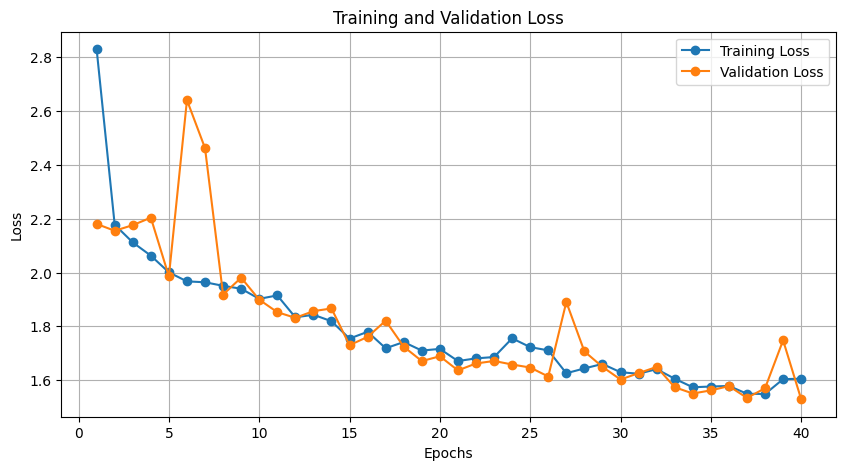

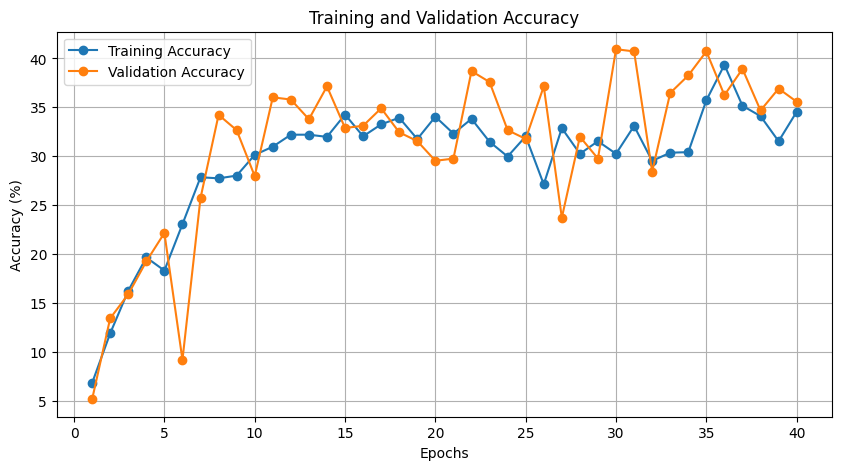

In [36]:
import matplotlib.pyplot as plt


epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Grad-Cam Cancer-Location Feature by Hanan:

In [ ]:
import matplotlib.pyplot as plt
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.conv3
cam = GradCAM(model=model, target_layers=[target_layer])

correct_images = []
incorrect_images = []

# Classify all validation images and separate them
for i in range(len(val_dataset)):
    img, true_label = val_dataset[i]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred_label = torch.max(outputs, 1)
        pred_label = pred_label.item()

    correct = (true_label == pred_label)
    # Store tuples (img, true_label, pred_label)
    if correct:
        correct_images.append((img, true_label, pred_label))
    else:
        incorrect_images.append((img, true_label, pred_label))

# Function to plot Grad-CAM for a list of images
def plot_gradcam(images_list, title, num_display=6):
    plt.figure(figsize=(15,10))
    for i in range(min(num_display, len(images_list))):
        img, true_label, pred_label = images_list[i]
        input_tensor = img.unsqueeze(0).to(device)
        rgb_img = img.permute(1,2,0).cpu().numpy()

        grayscale_cam = cam(input_tensor=input_tensor)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        true_class = train_data.classes[true_label]
        pred_class = train_data.classes[pred_label]

        plt.subplot(2, 3, i+1)
        plt.imshow(visualization)
        plt.title(f"True: {true_class}\nPred: {pred_class} {'✔' if true_label==pred_label else '✖'}")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot correct predictions
plot_gradcam(correct_images, "Correct Predictions (Grad-CAM)")

# Plot incorrect predictions
plot_gradcam(incorrect_images, "Incorrect Predictions (Grad-CAM)")
